# Calculating swap fee based on fixed point volatility
We are referencing the fee calculation from this demo: https://github.com/jpw993/ethlondon_dynamicfeehook/blob/e4d75517e2cc3e0e4f474a14d4132d31e8c745c7/datascience/Fees.ipynb


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [351]:
NUM_FRAC_BITS = 40 # Number of fractional bit for our fixed point numbers
MIN_FEE = 3.5 # A minimum fee of 3.5 USD taken from reference
MIN_FEE_FIXED = int(MIN_FEE * 2**NUM_FRAC_BITS) # The fixed point representation of this number
print("MIN_FEE_FIXED: {}".format(MIN_FEE_FIXED))

LONG_ETH_VOL = 0.6 # Long term ETH volatility, taken from reference
LONG_ETH_VOL_FIXED = int(LONG_ETH_VOL * 2**NUM_FRAC_BITS)
print("LONG_ETH_VOL: {}".format(LONG_ETH_VOL_FIXED))

ETH_VOL_SCALE = 150 # Volume scale factor, taken from source
ETH_VOL_SCALE_FIXED = int(ETH_VOL_SCALE * 2**NUM_FRAC_BITS)
print("LONG_ETH_VOL: {}".format(LONG_ETH_VOL_FIXED))

ETH_PRICE = 3700 # Pick an USD/ETH price

# This assumes that both left and right are fixed point numbers, i.e. left = l * SCALE_FACTOR, right ...
# Result should also be a fixed point number, i.e. result = l * r * SCALE_FACTOR
# When we multiply left and right, we have an extra factor of SCALE_FACTOR, left * right = l * SCALE_FACTOR * r * SCALE_FACTOR
# So we reduce by SCALE_FACTOR
def fixed_point_mul(left, right): 
    result = left * right >> NUM_FRAC_BITS
    return result


# This assumes that both num and den are also fixed point numbers, i.e. num = n * SCALE_FACTOR, den = d * SCALE_FACTOR
# Result should be a fixed point number i.e. result = n/d * SCALE_FACTOR
# So we multiply num by SCALE_FACTOR before dividing, 
# num * SCALE_FACTOR / den  = ((n * SCALE_FACTOR) * SCALE_FACTOR)/(d * SCALE_FACTOR) = n/d * SCALE_FACTOR 
def fixed_point_divide(num, den):
    result = (num << NUM_FRAC_BITS) // den
    return result

# Fee calculation taken from reference
def calculateFee(volume, volatility, price):
    scaled_volume = fixed_point_divide(volume, ETH_VOL_SCALE)
    scaled_vol = fixed_point_divide(volatility, LONG_ETH_VOL_FIXED)
    scaled_vol2 = fixed_point_mul(scaled_vol, scaled_vol)
    constant_factor = 2
    
    fee_per_lot = MIN_FEE_FIXED + constant_factor * fixed_point_mul(scaled_volume, scaled_vol2)

    return fee_per_lot 
    # return int(fee_per_lot / price / 1e10)


MIN_FEE_FIXED: 3848290697216
LONG_ETH_VOL: 659706976665
LONG_ETH_VOL: 659706976665


Text(0.5, 1.0, 'Fee for Swaps at 60% Volatility')

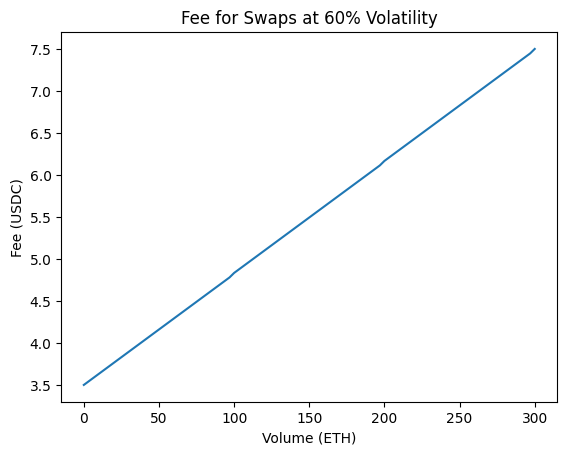

In [354]:
volatility = 0.6
volatility_fixed = int(volatility * (2**NUM_FRAC_BITS))
volume = np.linspace(0, 300, 100)

fees = [calculateFee(int(v), volatility_fixed, ETH_PRICE) * 2**-NUM_FRAC_BITS for v in volume]

plt.plot(volume, fees)

# Add labels and title
plt.xlabel('Volume (ETH)')
plt.ylabel('Fee (USDC)')
plt.title('Fee for Swaps at 60% Volatility')

Text(0.5, 1.0, 'Fee for 150ETH Swap')

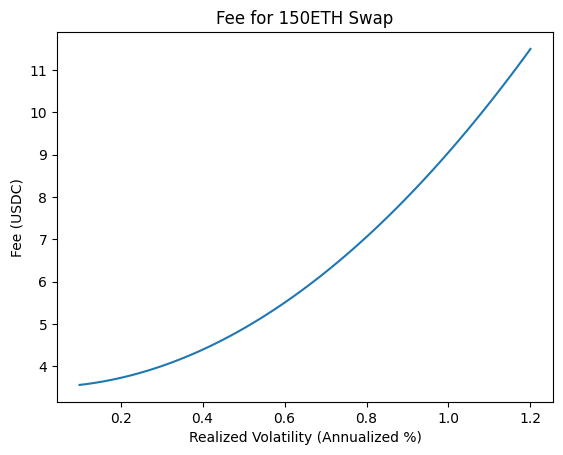

In [355]:
volatility = np.linspace(0.1, 1.2, 100)
volume = 150
fees = [calculateFee(volume, int(v * 2**NUM_FRAC_BITS), ETH_PRICE) * 2**-NUM_FRAC_BITS for v in volatility]
plt.plot(volatility, fees)

# Add labels and title
plt.xlabel('Realized Volatility (Annualized %)')
plt.ylabel('Fee (USDC)')
plt.title('Fee for 150ETH Swap')


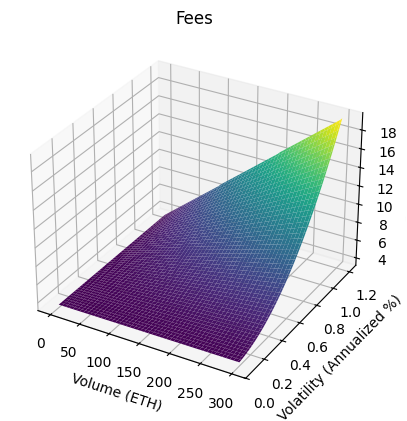

In [357]:
# Volatility and trade volume points
volatility = np.linspace(0.08, 1.2, 100) 
volume = np.linspace(0, 300, 100) # Volumes from 1 to 301

# Generate meshgrid for 3D plot
vol, volat = np.meshgrid(volume, volatility)

# Calculate fees for the meshgrid
fees = np.array([calculateFee(int(v), int(volat_val*2**NUM_FRAC_BITS), ETH_PRICE) * 2**-NUM_FRAC_BITS for v, volat_val in zip(np.ravel(vol), np.ravel(volat))])
fees = fees.reshape(vol.shape) # * 2**-num_factional_bits

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(vol, volat, fees, cmap='viridis')

# Set labels and title
ax.set_xlabel('Volume (ETH)')
ax.set_ylabel('Volatility (Annualized %)')
ax.set_zlabel('Fee (USDC)')
ax.set_title('Fees')

plt.show()